# Time Series as Features

### O que é Dependência Serial?
Em lições anteriores, investigamos propriedades de séries temporais que eram mais facilmente modeladas como propriedades dependentes do tempo, ou seja, com características que poderíamos derivar diretamente do índice de tempo. Algumas propriedades de séries temporais, no entanto, só podem ser modeladas como propriedades serialmente dependentes, ou seja, usando como recursos valores passados da série de destino. A estrutura dessas séries temporais pode não ser aparente a partir de um gráfico ao longo do tempo; plotados em relação a valores passados, no entanto, a estrutura fica clara - como vemos na figura abaixo.

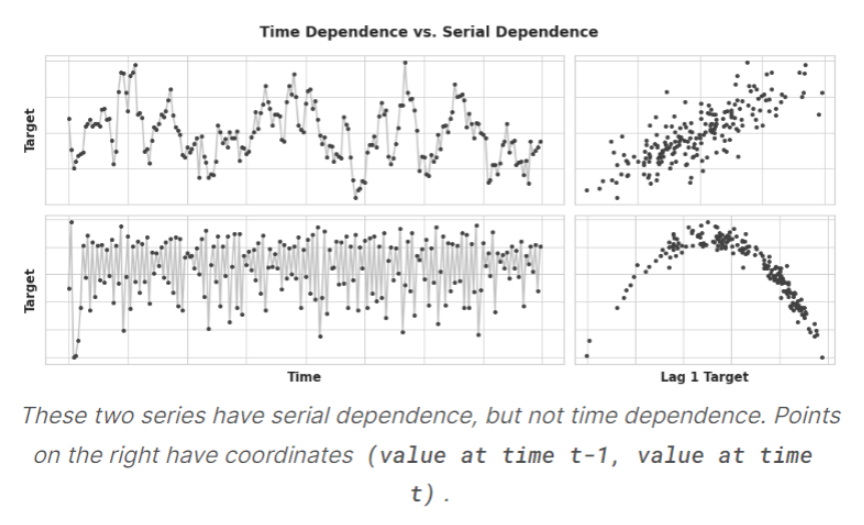

Com tendência e sazonalidade, treinamos modelos para ajustar curvas a gráficos como os da esquerda na figura acima - os modelos estavam aprendendo a dependência do tempo. O objetivo desta lição é treinar modelos para ajustar curvas a gráficos como os da direita -- queremos que eles aprendam a dependência serial.

### Ciclos
Uma maneira especialmente comum de manifestação da dependência serial é em ciclos. Ciclos são padrões de crescimento e declínio em uma série temporal associados a como o valor em uma série em um momento depende de valores em momentos anteriores, mas não necessariamente no próprio passo de tempo. O comportamento cíclico é característico de sistemas que podem afetar a si mesmos ou cujas reações persistem ao longo do tempo. Economias, epidemias, populações de animais, erupções vulcânicas e fenômenos naturais semelhantes geralmente apresentam comportamento cíclico.

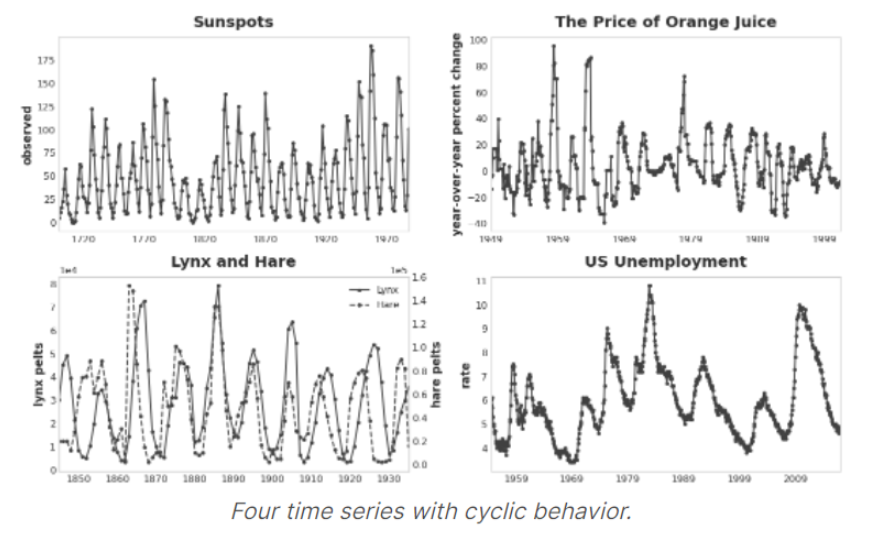

O que distingue o comportamento cíclico da sazonalidade é que os ciclos não são necessariamente dependentes do tempo, como as estações. O que acontece em um ciclo é menos sobre a data específica da ocorrência e mais sobre o que aconteceu no passado recente. A independência (pelo menos relativa) do tempo significa que o comportamento cíclico pode ser muito mais irregular do que a sazonalidade.

### Séries defasadas e gráficos de defasagem
Para investigar uma possível dependência serial (como ciclos) em uma série temporal, precisamos criar cópias "defasadas" da série. Atrasar uma série temporal significa deslocar seus valores uma ou mais etapas para frente, ou equivalentemente, deslocar os tempos em seu índice para trás uma ou mais etapas. Em ambos os casos, o efeito é que as observações na série defasada parecerão ter acontecido mais tarde.

Isso mostra a taxa mensal de desemprego nos EUA (y) juntamente com sua primeira e segunda séries defasadas (y_lag_1 e y_lag_2, respectivamente). Observe como os valores da série defasada são deslocados para frente no tempo.

In [3]:
import pandas as pd

# Federal Reserve dataset: https://www.kaggle.com/federalreserve/interest-rates
reserve = pd.read_csv(
    "pasta/reserve.csv",
    parse_dates={'Date': ['Year', 'Month', 'Day']},
    index_col='Date',
)

y = reserve.loc[:, 'Unemployment Rate'].dropna().to_period('M')
df = pd.DataFrame({
    'y': y,
    'y_lag_1': y.shift(1),
    'y_lag_2': y.shift(2),    
})

df.head()

,y,y_lag_1,y_lag_2
Date,,,
1954-07,5.8,NaN,NaN
1954-08,6.0,5.8,NaN
1954-09,6.1,6.0,5.8
1954-10,5.7,6.1,6.0
1954-11,5.3,5.7,6.1


Ao atrasar uma série temporal, podemos fazer com que seus valores passados pareçam contemporâneos aos valores que estamos tentando prever (na mesma linha, em outras palavras). Isso torna as séries defasadas úteis como recursos para modelar a dependência serial. Para prever a série da taxa de desemprego dos EUA, poderíamos usar y_lag_1 e y_lag_2 como recursos para prever a meta y. Isso preveria a taxa de desemprego futura em função da taxa de desemprego nos dois meses anteriores.

### Gráficos de atraso
Um gráfico de defasagem de uma série temporal mostra seus valores plotados em relação aos seus desfasamentos. A dependência serial em uma série temporal geralmente se torna aparente ao observar um gráfico de defasagem. Podemos ver neste gráfico de defasagem do desemprego nos EUA que existe uma relação forte e aparentemente linear entre a taxa de desemprego atual e as taxas passadas.

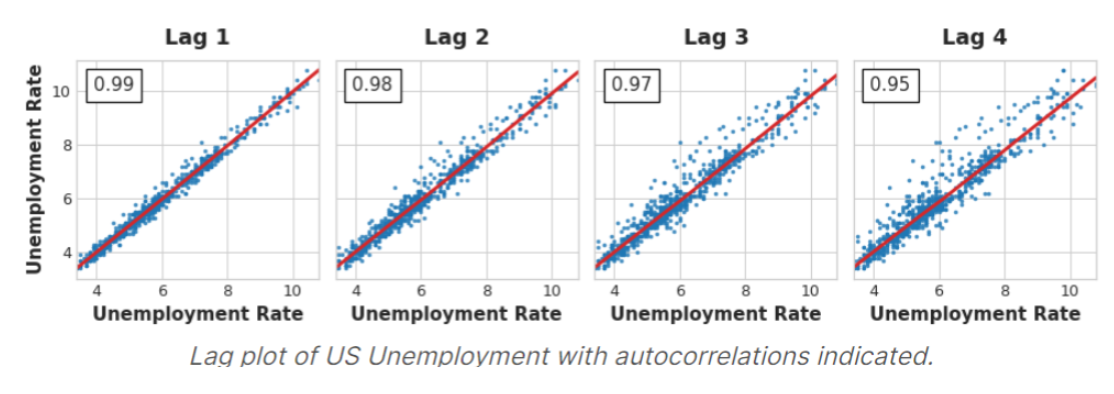

A medida de dependência serial mais comumente usada é conhecida como autocorrelação, que é simplesmente a correlação que uma série temporal tem com uma de suas defasagens. O desemprego nos EUA tem uma autocorrelação de 0,99 na defasagem 1, 0,98 na defasagem 2 e assim por diante.

### Escolhendo atrasos
Ao escolher atrasos para usar como recursos, geralmente não será útil incluir todos os atrasos com uma autocorrelação grande. No Desemprego dos EUA, por exemplo, a autocorrelação na defasagem 2 pode resultar inteiramente de informações "deterioradas" da defasagem 1 - apenas correlação que é transportada da etapa anterior. Se o lag 2 não contiver nada de novo, não haverá motivo para incluí-lo se já tivermos o lag 1.

A autocorrelação parcial informa a correlação de um atraso contabilizando todos os atrasos anteriores - a quantidade de "nova" correlação que o atraso contribui, por assim dizer. Traçar a autocorrelação parcial pode ajudá-lo a escolher quais recursos de atraso usar. Na figura abaixo, a defasagem 1 a 6 está fora dos intervalos de "sem correlação" (em azul), portanto, podemos escolher as defasagens 1 a 6 como recursos para Desemprego nos EUA. (O atraso 11 é provavelmente um falso positivo.)

<img src="img/l.png">

Um gráfico como o acima é conhecido como correlograma. O correlograma é para características de atraso essencialmente o que o periodograma é para características de Fourier.

Finalmente, precisamos estar cientes de que a autocorrelação e a autocorrelação parcial são medidas de dependência linear. Como as séries temporais do mundo real geralmente têm dependências não lineares substanciais, é melhor observar um gráfico de atraso (ou usar alguma medida mais geral de dependência, como informações mútuas) ao escolher recursos de atraso. A série Sunspots tem defasagens com dependência não linear que podemos ignorar com autocorrelação.

<img src="img/m.png">

Relações não lineares como essas podem ser transformadas em lineares ou aprendidas por um algoritmo apropriado.

## Exemplo - Tendências da gripe
O conjunto de dados do Flu Trends contém registros de consultas médicas para gripe durante semanas entre 2009 e 2016. Nosso objetivo é prever o número de casos de gripe para as próximas semanas.

Faremos duas abordagens. No primeiro, vamos prever as consultas médicas usando recursos de atraso. Nossa segunda abordagem será prever as consultas médicas usando defasagens de outro conjunto de séries temporais: termos de pesquisa relacionados à gripe conforme capturados pelo Google Trends.

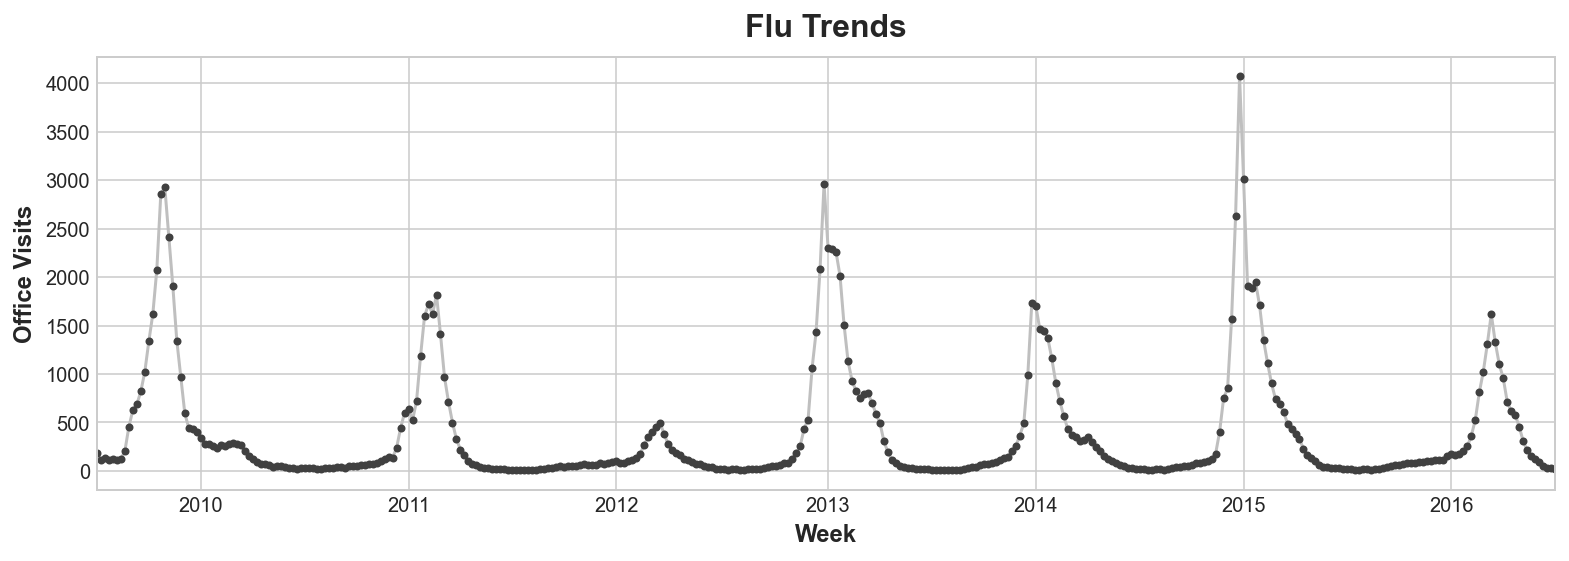

In [1]:
from pathlib import Path
from warnings import simplefilter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.signal import periodogram
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from statsmodels.graphics.tsaplots import plot_pacf

simplefilter("ignore")

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 4))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
)
%config InlineBackend.figure_format = 'retina'


def lagplot(x, y=None, lag=1, standardize=False, ax=None, **kwargs):
    from matplotlib.offsetbox import AnchoredText
    x_ = x.shift(lag)
    if standardize:
        x_ = (x_ - x_.mean()) / x_.std()
    if y is not None:
        y_ = (y - y.mean()) / y.std() if standardize else y
    else:
        y_ = x
    corr = y_.corr(x_)
    if ax is None:
        fig, ax = plt.subplots()
    scatter_kws = dict(
        alpha=0.75,
        s=3,
    )
    line_kws = dict(color='C3', )
    ax = sns.regplot(x=x_,
                     y=y_,
                     scatter_kws=scatter_kws,
                     line_kws=line_kws,
                     lowess=True,
                     ax=ax,
                     **kwargs)
    at = AnchoredText(
        f"{corr:.2f}",
        prop=dict(size="large"),
        frameon=True,
        loc="upper left",
    )
    at.patch.set_boxstyle("square, pad=0.0")
    ax.add_artist(at)
    ax.set(title=f"Lag {lag}", xlabel=x_.name, ylabel=y_.name)
    return ax


def plot_lags(x, y=None, lags=6, nrows=1, lagplot_kwargs={}, **kwargs):
    import math
    kwargs.setdefault('nrows', nrows)
    kwargs.setdefault('ncols', math.ceil(lags / nrows))
    kwargs.setdefault('figsize', (kwargs['ncols'] * 2, nrows * 2 + 0.5))
    fig, axs = plt.subplots(sharex=True, sharey=True, squeeze=False, **kwargs)
    for ax, k in zip(fig.get_axes(), range(kwargs['nrows'] * kwargs['ncols'])):
        if k + 1 <= lags:
            ax = lagplot(x, y, lag=k + 1, ax=ax, **lagplot_kwargs)
            ax.set_title(f"Lag {k + 1}", fontdict=dict(fontsize=14))
            ax.set(xlabel="", ylabel="")
        else:
            ax.axis('off')
    plt.setp(axs[-1, :], xlabel=x.name)
    plt.setp(axs[:, 0], ylabel=y.name if y is not None else x.name)
    fig.tight_layout(w_pad=0.1, h_pad=0.1)
    return fig



flu_trends = pd.read_csv("pasta/flu-trends.csv")
flu_trends.set_index(
    pd.PeriodIndex(flu_trends.Week, freq="W"),
    inplace=True,
)
flu_trends.drop("Week", axis=1, inplace=True)

ax = flu_trends.FluVisits.plot(title='Flu Trends', **plot_params)
_ = ax.set(ylabel="Office Visits")

plt.show()

Nossos dados do Flu Trends mostram ciclos irregulares em vez de uma sazonalidade regular: o pico tende a ocorrer por volta do ano novo, mas às vezes mais cedo ou mais tarde, às vezes maior ou menor. A modelagem desses ciclos com recursos de atraso permitirá que nosso previsor reaja dinamicamente às mudanças nas condições, em vez de ficar restrito a datas e horas exatas, como nos recursos sazonais.

Vamos dar uma olhada nos gráficos de atraso e autocorrelação primeiro:

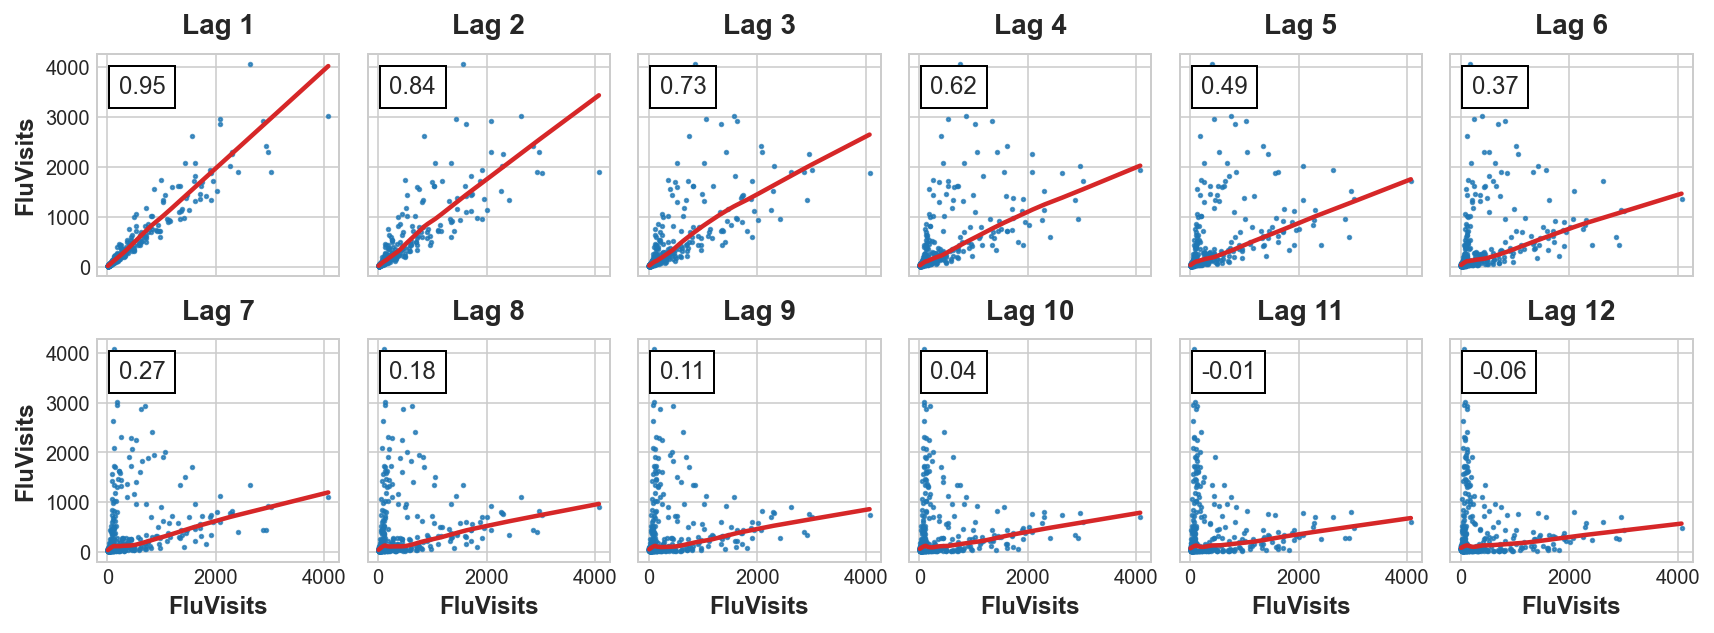

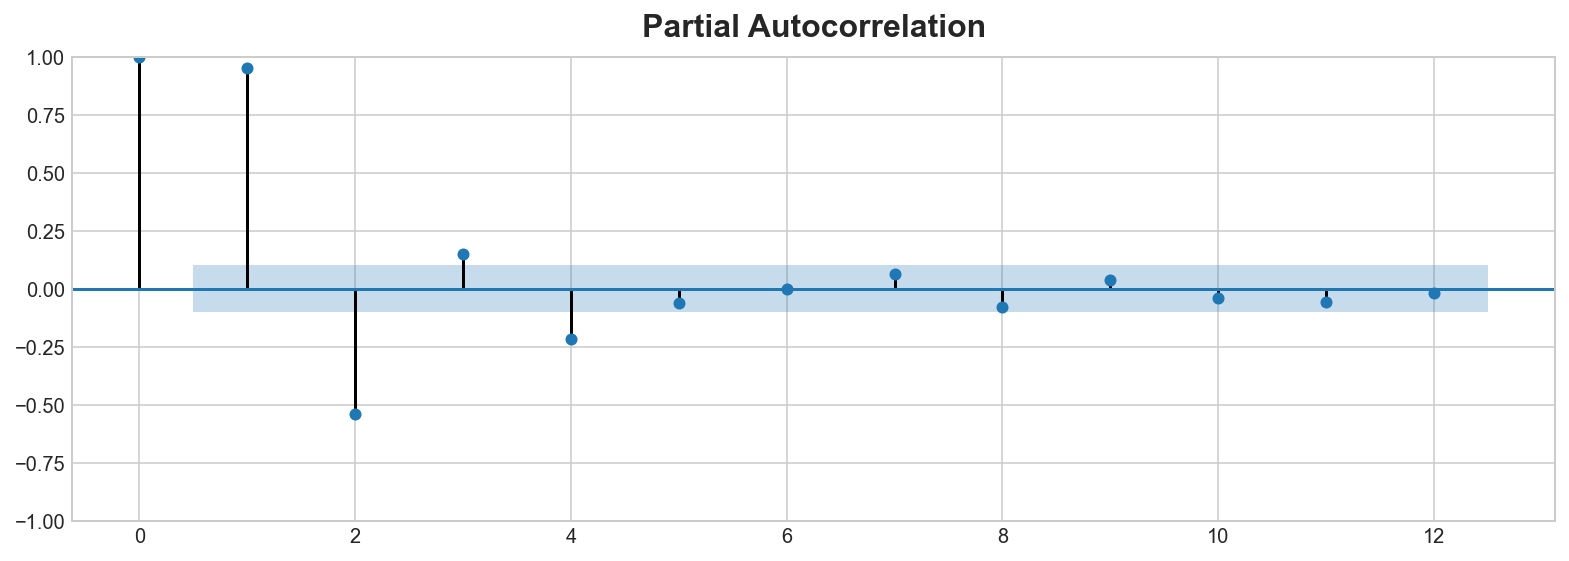

In [2]:
_ = plot_lags(flu_trends.FluVisits, lags=12, nrows=2)
_ = plot_pacf(flu_trends.FluVisits, lags=12)

plt.show()

Os gráficos de defasagem indicam que a relação de FluVisits com suas defasagens é principalmente linear, enquanto as autocorrelações parciais sugerem que a dependência pode ser capturada usando desfasamentos 1, 2, 3 e 4. Podemos desfasar uma série temporal em Pandas com o método de deslocamento. Para esse problema, preencheremos os valores ausentes que o atraso cria com 0,0.

In [3]:
def make_lags(ts, lags):
    return pd.concat(
        {
            f'y_lag_{i}': ts.shift(i)
            for i in range(1, lags + 1)
        },
        axis=1)


X = make_lags(flu_trends.FluVisits, lags=4)
X = X.fillna(0.0)

Nas lições anteriores, pudemos criar previsões para quantas etapas quiséssemos além dos dados de treinamento. Ao usar recursos de atraso, no entanto, estamos limitados a prever etapas de tempo cujos valores defasados estão disponíveis. Usando um recurso de atraso 1 na segunda-feira, não podemos fazer uma previsão para quarta-feira porque o valor de atraso 1 necessário é terça-feira, o que ainda não aconteceu.

Veremos estratégias para lidar com esse problema na Lição 6. Para este exemplo, usaremos apenas valores de um conjunto de teste.

In [4]:
# Create target series and data splits
y = flu_trends.FluVisits.copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=60, shuffle=False)

# Fit and predict
model = LinearRegression()  # `fit_intercept=True` since we didn't use DeterministicProcess
model.fit(X_train, y_train)
y_pred = pd.Series(model.predict(X_train), index=y_train.index)
y_fore = pd.Series(model.predict(X_test), index=y_test.index)

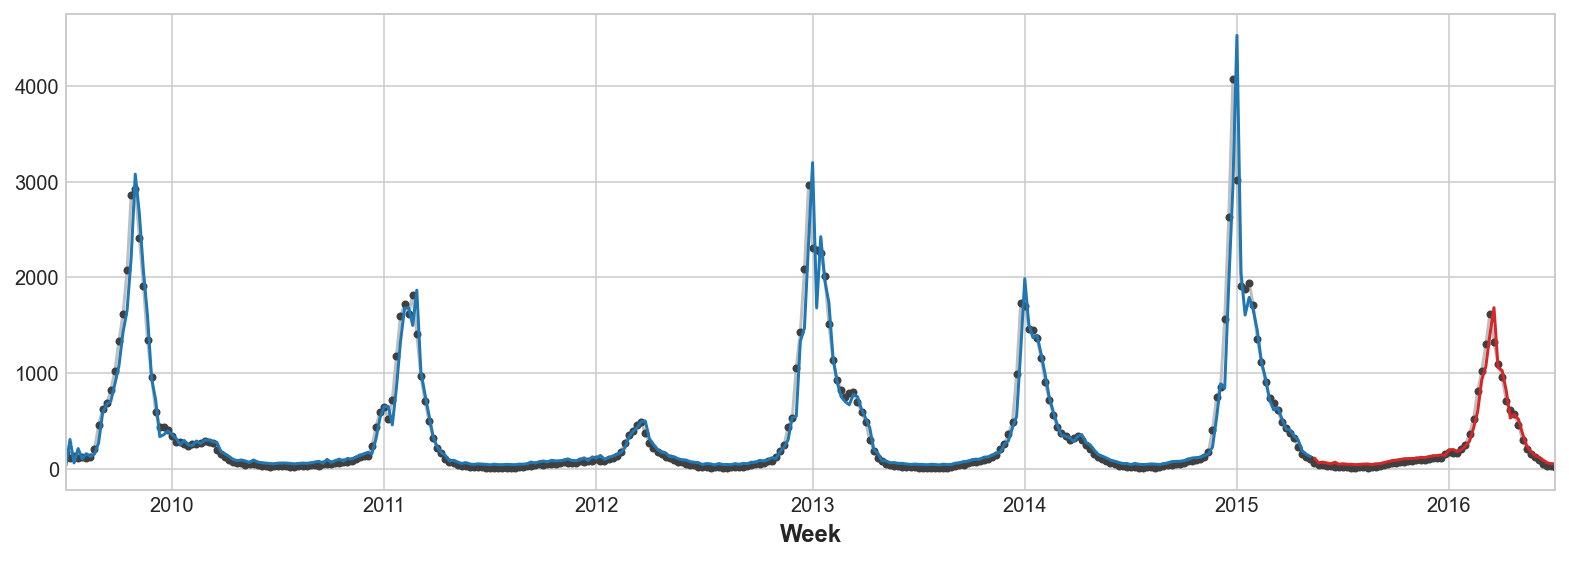

In [5]:
ax = y_train.plot(**plot_params)
ax = y_test.plot(**plot_params)
ax = y_pred.plot(ax=ax)
_ = y_fore.plot(ax=ax, color='C3')

plt.show()

Observando apenas os valores de previsão, podemos ver como nosso modelo precisa de uma etapa de tempo para reagir a mudanças repentinas na série de destino. Esta é uma limitação comum de modelos que usam apenas defasagens da série alvo como características.

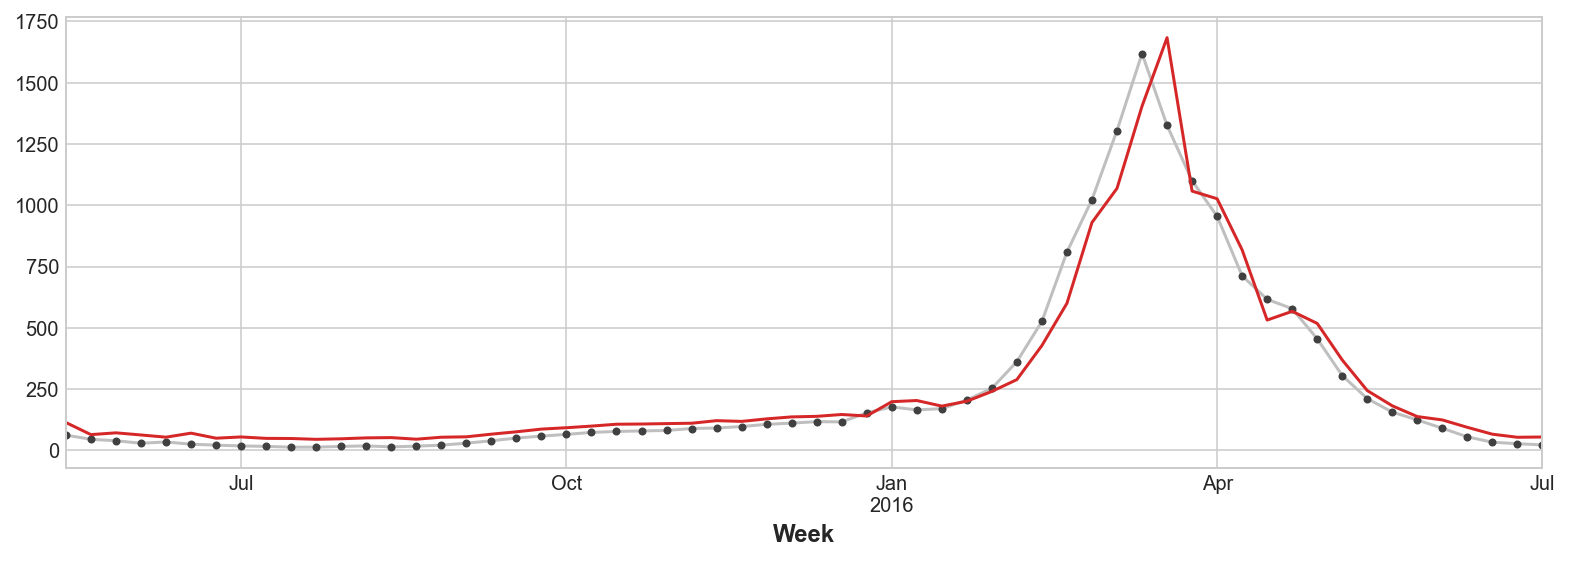

In [6]:
ax = y_test.plot(**plot_params)
_ = y_fore.plot(ax=ax, color='C3')

plt.show()

Para melhorar a previsão poderíamos tentar encontrar indicadores antecedentes, séries temporais que pudessem fornecer um "aviso antecipado" para mudanças nos casos de gripe. Para nossa segunda abordagem, adicionaremos aos nossos dados de treinamento a popularidade de alguns termos de pesquisa relacionados à gripe, conforme medido pelo Google Trends.

Traçar a frase de pesquisa 'FluCough' contra o alvo 'FluVisits' sugere que esses termos de pesquisa podem ser úteis como indicadores principais: pesquisas relacionadas à gripe tendem a se tornar mais populares nas semanas anteriores às visitas ao consultório.

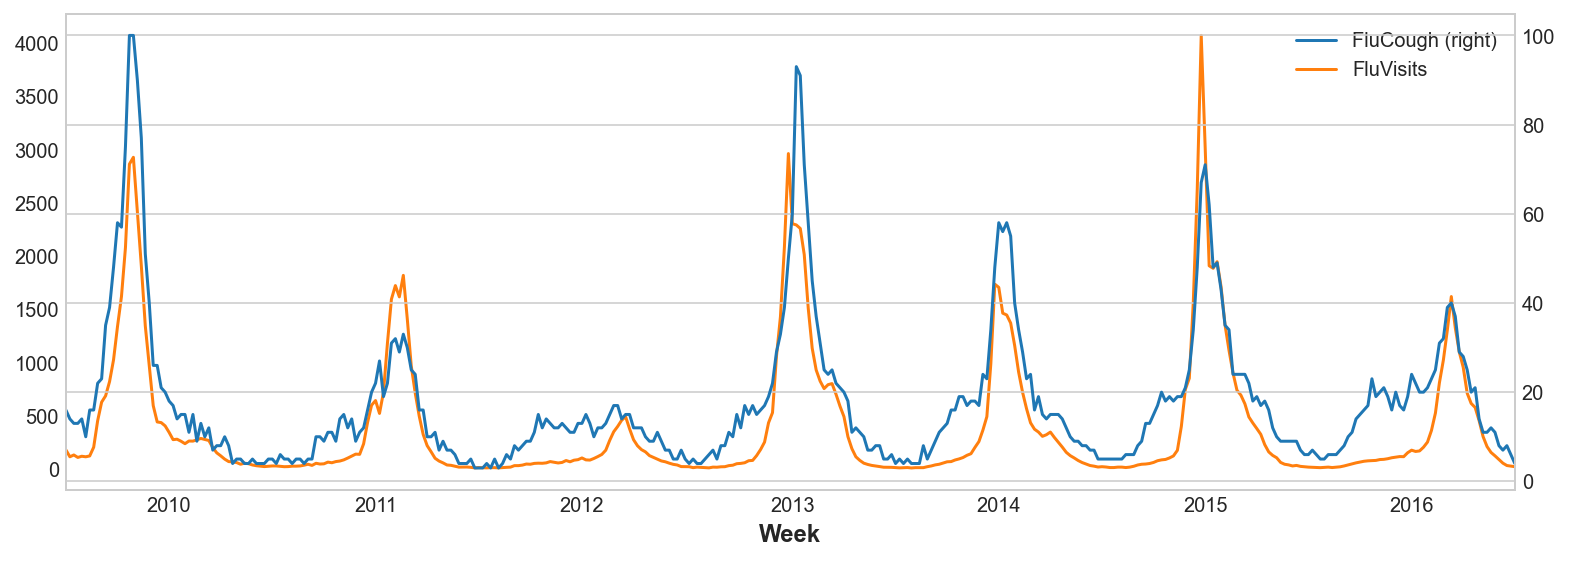

In [7]:
ax = flu_trends.plot(
    y=["FluCough", "FluVisits"],
    secondary_y="FluCough",
)

plt.show()

O conjunto de dados contém 129 desses termos, mas usaremos apenas alguns.

In [8]:
search_terms = ["FluContagious", "FluCough", "FluFever", "InfluenzaA", "TreatFlu", "IHaveTheFlu", "OverTheCounterFlu", "HowLongFlu"]

# Create three lags for each search term
X0 = make_lags(flu_trends[search_terms], lags=3)

# Create four lags for the target, as before
X1 = make_lags(flu_trends['FluVisits'], lags=4)

# Combine to create the training data
X = pd.concat([X0, X1], axis=1).fillna(0.0)

Nossas previsões são um pouco mais grosseiras, mas nosso modelo parece ser mais capaz de antecipar aumentos repentinos nas visitas de gripe, sugerindo que as várias séries temporais de popularidade de pesquisa foram realmente eficazes como indicadores principais.

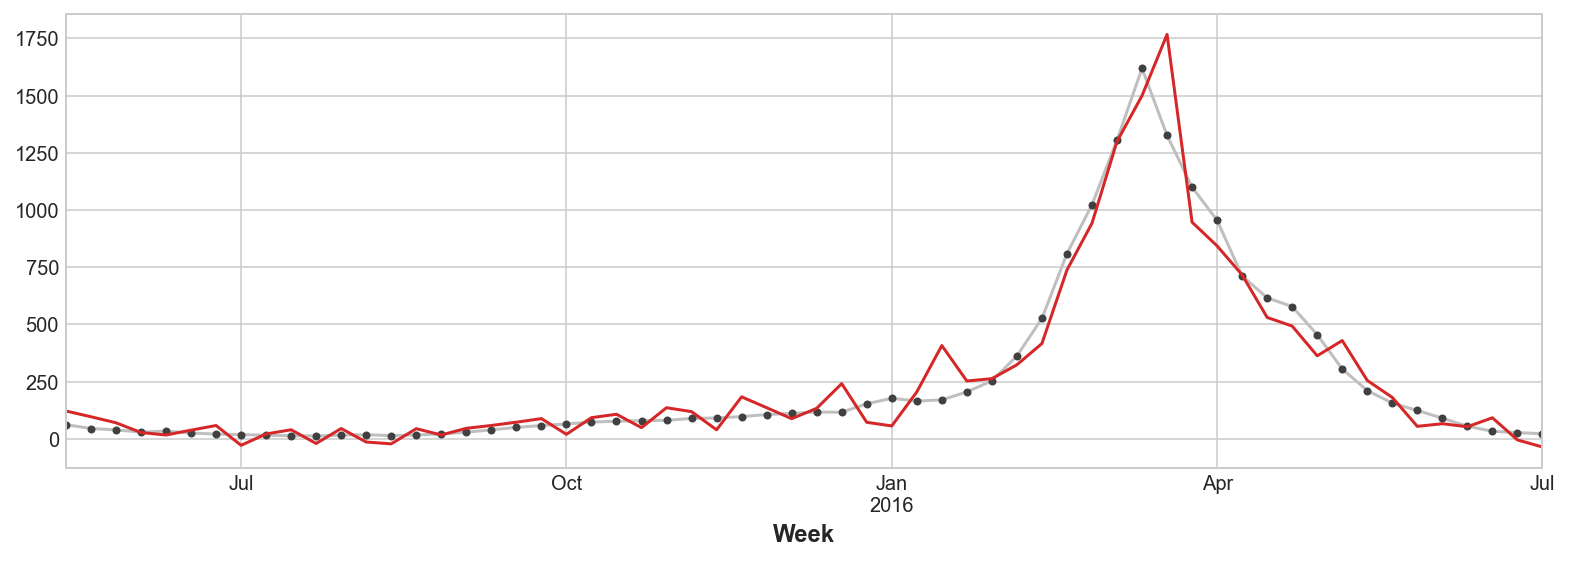

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=60, shuffle=False)

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = pd.Series(model.predict(X_train), index=y_train.index)
y_fore = pd.Series(model.predict(X_test), index=y_test.index)

ax = y_test.plot(**plot_params)
_ = y_fore.plot(ax=ax, color='C3')

plt.show()

As séries temporais ilustradas nesta lição são o que você pode chamar de "puramente cíclicas": elas não têm tendência ou sazonalidade óbvias. Não é incomum, porém, que as séries temporais possuam tendência, sazonalidade e ciclos - todos os três componentes ao mesmo tempo. Você pode modelar essas séries com regressão linear apenas adicionando os recursos apropriados para cada componente. Você pode até combinar modelos treinados para aprender os componentes separadamente, o que aprenderemos a fazer na próxima lição com a previsão de híbridos.